# Setup and Libraries

In [147]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parent


# Load the CSV and parse Imaging Protocol

In [148]:
CSV_DIR = ROOT_DIR / "csv_dir"
original_df = pd.read_csv(CSV_DIR / "MCSA_all.csv")


# little adjustments
original_df["Subject ID"] = original_df["Subject ID"].astype("category")
original_df["Image ID"] = original_df["Image ID"].astype("category")
original_df["Weight"] = original_df["Weight"].replace(0, np.nan)
original_df["Age"] = original_df["Age"].replace(0, np.nan)
original_df["Study Date"] = pd.to_datetime(original_df["Study Date"], errors="coerce")

print(original_df.columns)
print(len(original_df))

fields = [
    "Acquisition Plane",
    "Slice Thickness",
    "Matrix Z",
    "Acquisition Type",
    "Manufacturer",
    "Mfg Model",
    "Field Strength",
    "Weighting",
]

numeric_fields = ["Slice Thickness", "Matrix Z", "Field Strength"]


def parse_imaging_protocol(text):
    if pd.isna(text):
        return {}

    items = text.split(";")
    parsed = {}

    for item in items:
        if "=" in item:
            key, value = item.split("=", 1)
            parsed[key.strip()] = value.strip()

    return parsed


# Parse the column into dictionaries
protocol_parsed = original_df["Imaging Protocol"].apply(parse_imaging_protocol)

# Create new columns
for field in fields:
    original_df[field] = protocol_parsed.apply(lambda x: x.get(field, np.nan))


for field in numeric_fields:
    original_df[field] = pd.to_numeric(original_df[field], errors="coerce")

print(original_df.columns)

Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Visit', 'Study Date',
       'Archive Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID'],
      dtype='object')
14886
Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Visit', 'Study Date',
       'Archive Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID', 'Acquisition Plane', 'Slice Thickness',
       'Matrix Z', 'Acquisition Type', 'Manufacturer', 'Mfg Model',
       'Field Strength', 'Weighting'],
      dtype='object')


# Filtered dataframe

In [151]:
# Apply filters
weighting_filter = original_df["Weighting"] == "T1"

df = original_df[
    (original_df["Modality"] == "MRI")
    & weighting_filter
    & (original_df["Matrix Z"] > 100)
    & (original_df["Slice Thickness"] < 1.4)
    & (original_df["Acquisition Type"] == "3D")
    & (original_df["Type"] == "Original")
].copy()

print(
    f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
)

Filtered dataset size: 3918 images from 2121 subjects.


### No filter

In [152]:
# df = original_df

In [153]:
df.head(2)

,Subject ID,Project,Sex,Weight,Visit,Study Date,Archive Date,Age,Modality,Description,...,Imaging Protocol,Image ID,Acquisition Plane,Slice Thickness,Matrix Z,Acquisition Type,Manufacturer,Mfg Model,Field Strength,Weighting
0,MCSA_00003,MCSA,X,NaN,4,1953-12-31,12/01/2023,NaN,MRI,Sag 3D MP-RAGE,...,Acquisition Plane=SAGITTAL;Slice Thickness=1.2...,10297203,SAGITTAL,1.2,166.0,3D,GE MEDICAL SYSTEMS,Signa HDxt,3.0,T1
4,MCSA_00011,MCSA,X,NaN,1,1950-04-04,12/01/2023,NaN,MRI,Sag 3D MP-RAGE,...,Acquisition Plane=SAGITTAL;Slice Thickness=1.2...,10297236,SAGITTAL,1.2,166.0,3D,GE MEDICAL SYSTEMS,Signa HDxt,3.0,T1


# Basic descriptions

In [154]:
# -------------------------------
# Column Names
# -------------------------------
print("=== Columns in the Dataset ===")
display(pd.DataFrame(df.columns, columns=["Column Names"]))

# -------------------------------
# Summary of Numeric Features
# -------------------------------
print("\n=== Numeric Features Summary ===")
display(df.describe().round(2))  # round to 2 decimals

# -------------------------------
# Summary of Categorical Features
# -------------------------------
print("\n=== Categorical Features Summary ===")
display(df.describe(include=["object", "category"]))

# -------------------------------
# Missing Values
# -------------------------------
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame(
    {"Missing Count": missing_count, "Missing %": missing_percent}
).sort_values(by="Missing Count", ascending=False)

print("\n=== Missing Values by Column ===")
display(missing_df)

# Find columns with at least one missing value
cols_with_missing = df.columns[df.isnull().any()]
print(f"Columns with missing values ({len(cols_with_missing)}):\n")

# for col in cols_with_missing:
#     print(f"--- {col} ---")
#     # Show up to 5 rows where this column is missing
#     display(df[df[col].isnull()].head(3))

=== Columns in the Dataset ===


,Column Names
0,Subject ID
1,Project
2,Sex
3,Weight
4,Visit
5,Study Date
6,Archive Date
7,Age
8,Modality
9,Description



=== Numeric Features Summary ===


,Weight,Visit,Study Date,Age,Slice Thickness,Matrix Z,Field Strength
count,0.0,3918.00,3918,0.0,3918.00,3918.00,3918.0
mean,NaN,3.61,1953-05-15 06:43:55.222052096,NaN,1.12,181.60,3.0
min,NaN,1.00,1950-01-11 00:00:00,NaN,0.80,165.00,3.0
25%,NaN,2.00,1950-05-12 06:00:00,NaN,1.20,166.00,3.0
50%,NaN,3.00,1952-10-11 00:00:00,NaN,1.20,166.00,3.0
75%,NaN,5.00,1955-04-11 18:00:00,NaN,1.20,166.00,3.0
max,NaN,19.00,1964-09-25 00:00:00,NaN,1.20,240.00,3.0
std,NaN,2.51,NaN,NaN,0.16,30.19,0.0



=== Categorical Features Summary ===


,Subject ID,Project,Sex,Archive Date,Modality,Description,Type,Imaging Protocol,Image ID,Acquisition Plane,Acquisition Type,Manufacturer,Mfg Model,Weighting
count,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918
unique,2121,1,1,10,1,5,1,6,3918,1,1,2,5,1
top,MCSA_49238,MCSA,X,12/10/2023,MRI,Sag 3D MP-RAGE,Original,Acquisition Plane=SAGITTAL;Slice Thickness=1.2...,11451717,SAGITTAL,3D,GE MEDICAL SYSTEMS,Signa HDxt,T1
freq,6,3918,3918,1729,3918,3092,3918,2002,1,3918,3918,3092,2002,3918



=== Missing Values by Column ===


,Missing Count,Missing %
Weight,3918,100.0
Age,3918,100.0
Subject ID,0,0.0
Sex,0,0.0
Project,0,0.0
Visit,0,0.0
Study Date,0,0.0
Archive Date,0,0.0
Modality,0,0.0
Description,0,0.0


Columns with missing values (2):



# Histograms

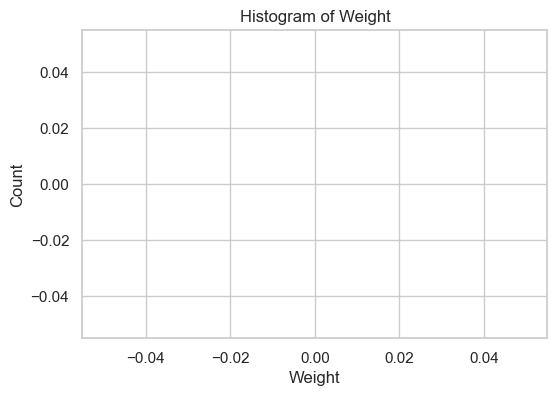

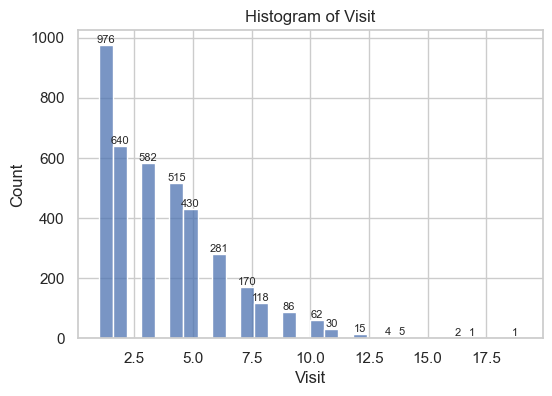

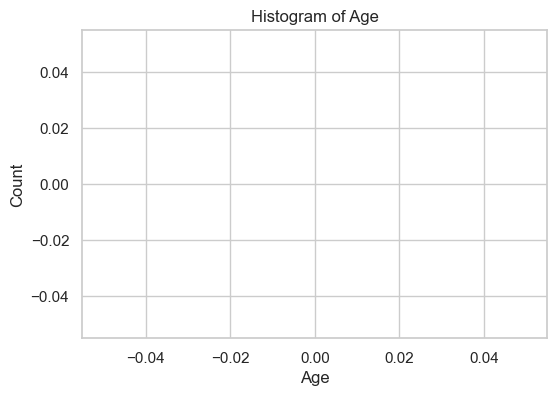

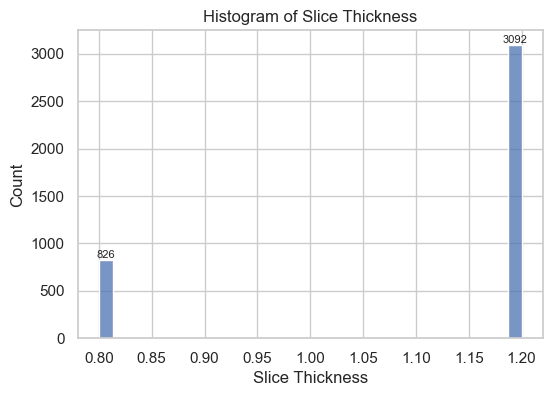

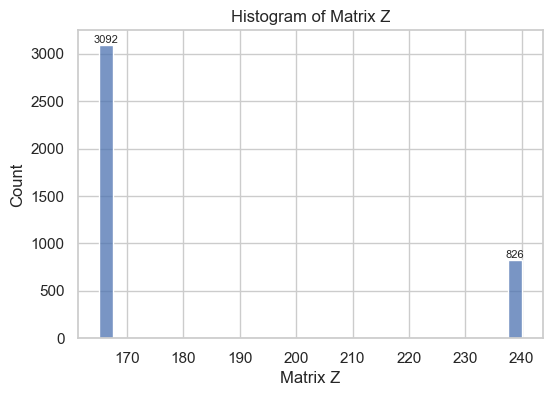

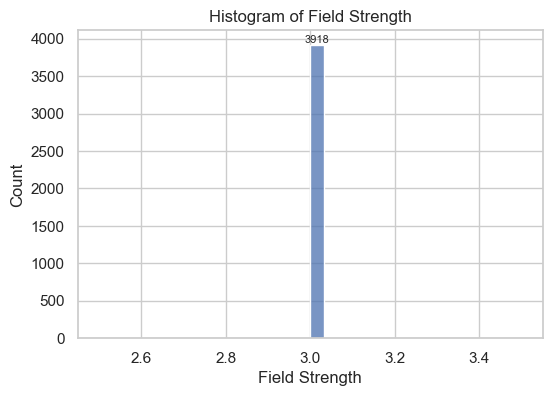

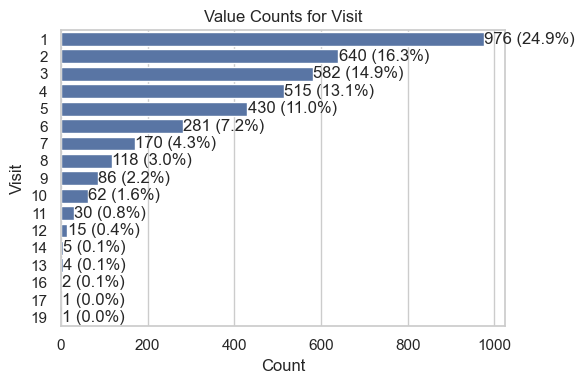

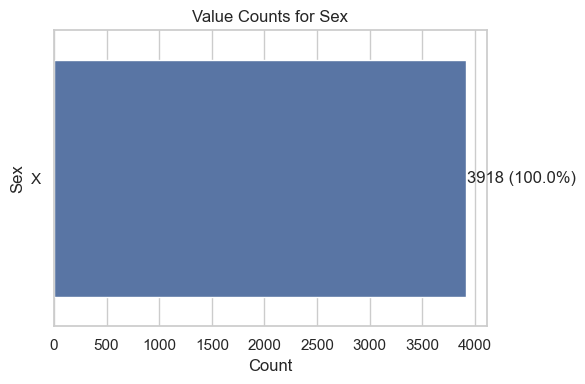

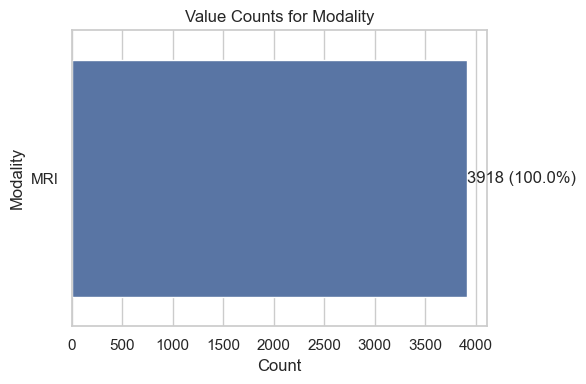

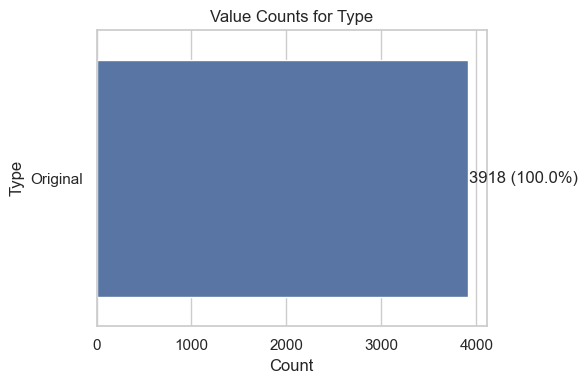

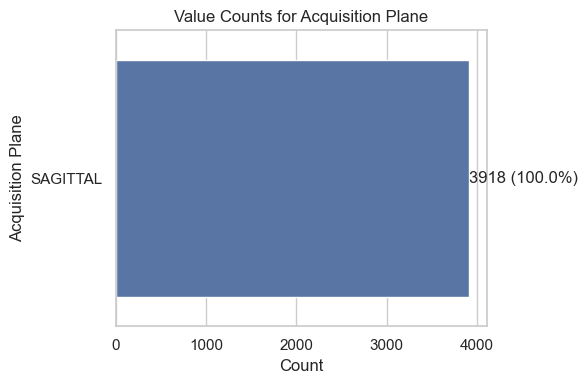

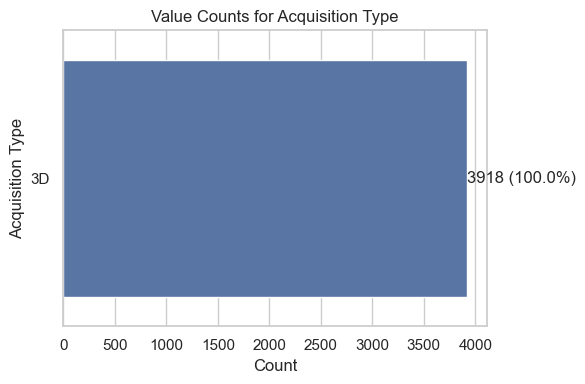

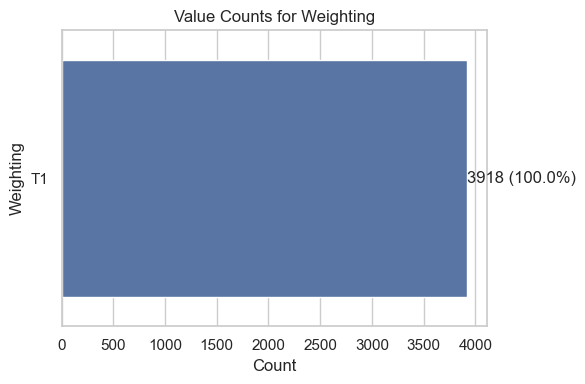

In [155]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

# -------------------------------
# Numeric Columns Histograms
# -------------------------------
for col in numeric_cols:
    plt.figure(figsize=(6, 4))

    # Plot histogram
    ax = sns.histplot(
        df[col].dropna(), bins=30, kde=False
    )  # disable KDE for counts clarity

    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    # Annotate counts on top of each bin
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # only annotate non-empty bins
            ax.text(
                patch.get_x() + patch.get_width() / 2,  # center of bin
                height + 0.5,  # slightly above the bar
                int(height),  # show integer count
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.show()

# -------------------------------
# Categorical Columns Bar Plots
# -------------------------------
categorical_cols = [
    "Visit",
    "Sex",
    "Research Group",
    "Modality",
    "Type",
    "Structure",
    "Laterality",
    "Image Type",
    "Registration",
    "Tissue",
    # Imaging Protocol–derived categorical columns
    "Acquisition Plane",
    "Acquisition Type",
    # "Manufacturer",
    # "Mfg Model",
    "Weighting",
]

categorical_cols = [col for col in categorical_cols if col in df.columns]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))

    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    order = counts.index

    ax = sns.countplot(y=col, data=df, order=order)

    # Add count + percentage labels
    for p, category in zip(ax.patches, order):
        count = counts[category]
        percent = 100 * count / total

        ax.text(
            p.get_width() + 0.5,
            p.get_y() + p.get_height() / 2,
            f"{count} ({percent:.1f}%)",
            va="center",
        )

    plt.title(f"Value Counts for {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


# Study dates

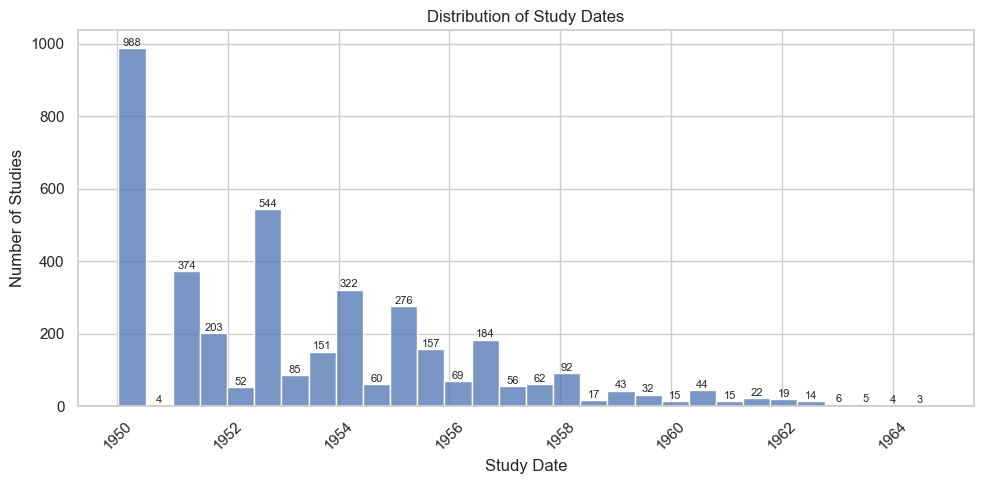

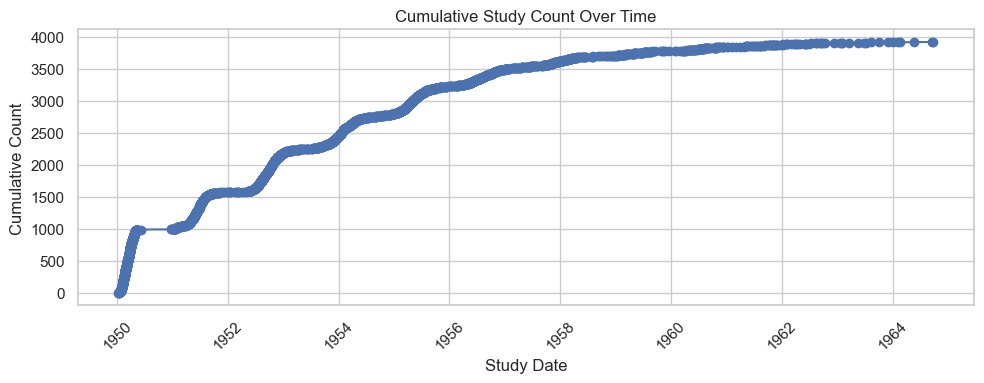

In [156]:
# -------------------------------
# Study Date Distribution
# -------------------------------


plt.figure(figsize=(10, 5))

# Histogram of study dates
ax = sns.histplot(df["Study Date"].dropna(), bins=30, kde=False)

plt.title("Distribution of Study Dates")
plt.xlabel("Study Date")
plt.ylabel("Number of Studies")

# Annotate counts on top of each bin
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.5,
            int(height),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# cumulative study count over time
plt.figure(figsize=(10, 4))
df_sorted = df.sort_values("Study Date")
df_sorted["Cumulative Count"] = range(1, len(df_sorted) + 1)
plt.plot(
    df_sorted["Study Date"], df_sorted["Cumulative Count"], marker="o", linestyle="-"
)
plt.title("Cumulative Study Count Over Time")
plt.xlabel("Study Date")
plt.ylabel("Cumulative Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Scans per session / coverage

Does a subject have more than one scan at a given visit?

How often does this happen?

In [157]:
df["Visit"] = df["Visit"].astype(str)

# scans per subject per visit
scans_per_subject_visit = (
    df.groupby(["Subject ID", "Visit"], observed=True)
    .size()
    .reset_index(name="n_scans")
)
# Keep only rows with at least 1 scan
scans_per_subject_visit = scans_per_subject_visit[
    scans_per_subject_visit["n_scans"] > 0
].copy()
# print(scans_per_subject_visit.head())
# print(scans_per_subject_visit["n_scans"].min())  # should now be >= 1


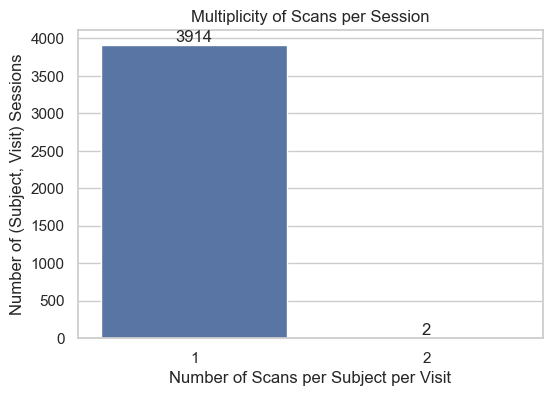

In [158]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="n_scans",
    data=scans_per_subject_visit,
    order=sorted(scans_per_subject_visit["n_scans"].unique()),
)

plt.xlabel("Number of Scans per Subject per Visit")
plt.ylabel("Number of (Subject, Visit) Sessions")
plt.title("Multiplicity of Scans per Session")

# Annotate counts on top of bars
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.show()


# Longitudinal analysis - for filtered subset

In [159]:
df["Visit"].unique()

array(['4', '1', '3', '5', '9', '10', '11', '2', '6', '8', '7', '12',
       '14', '16', '17', '19', '13'], dtype=object)

In [160]:
# Convert Visit to numeric
df["Visit_Num"] = pd.to_numeric(df["Visit"], errors="coerce")

# Sanity check
print(df["Visit_Num"].isna().sum())  # should be 0

# Scheduled visits are simply the numeric visit numbers
scheduled_visits = sorted(df["Visit_Num"].dropna().unique())

print("Scheduled Visits:", scheduled_visits)


scheduled_df = df.copy()

visits_per_subject = (
    scheduled_df.groupby("Subject ID", observed=True)["Visit_Num"]
    .nunique()
    .sort_values(ascending=False)
)

# Summary
summary_stats = visits_per_subject.describe()
print("Longitudinal Coverage per Subject:")
display(summary_stats)


0
Scheduled Visits: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(19)]
Longitudinal Coverage per Subject:


count    2121.000000
mean        1.846299
std         1.058633
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: Visit_Num, dtype: float64

In [161]:
df["Visit_Num"].unique()

array([ 4,  1,  3,  5,  9, 10, 11,  2,  6,  8,  7, 12, 14, 16, 17, 19, 13])

/tmp/ipykernel_40381/2482556886.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")


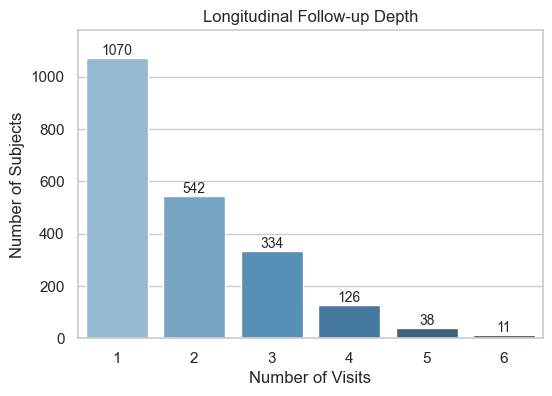

In [162]:
# Count how many subjects have N visits -- How many dropouts, How many fully followed subjects, wether dataset is shallow or deep
visit_counts = visits_per_subject.value_counts().sort_index()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")

# Annotate bars
for i, v in enumerate(visit_counts.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=10)

plt.xlabel("Number of Visits")
plt.ylabel("Number of Subjects")
plt.title("Longitudinal Follow-up Depth")
plt.ylim(0, visit_counts.values.max() * 1.1)
plt.show()


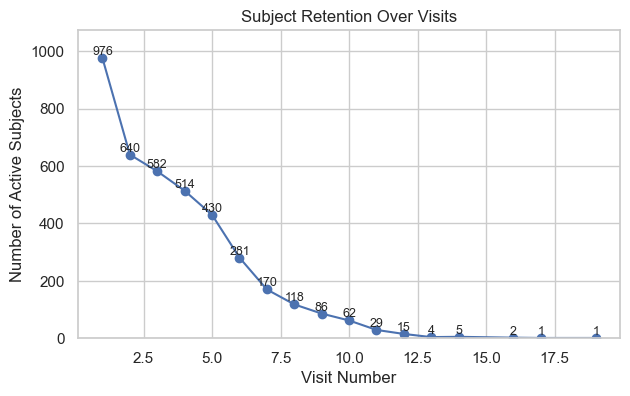

In [163]:
# how many subjects remain at each visit -- Where dropout occurs, Which visits are well populated
retention = (
    scheduled_df.groupby("Visit_Num", observed=True)["Subject ID"]
    .nunique()
    .sort_index()
)

plt.figure(figsize=(7, 4))
plt.plot(retention.index, retention.values, marker="o")

for x, y in zip(retention.index, retention.values):
    plt.text(x, y + 0.5, str(y), ha="center", va="bottom", fontsize=9)

plt.xlabel("Visit Number")
plt.ylabel("Number of Active Subjects")
plt.title("Subject Retention Over Visits")
plt.grid(True)
plt.ylim(0, retention.max() * 1.1)
plt.show()
